# Importação de bibliotecas

In [ ]:
!pip install mlflow --quiet

In [ ]:
!pip install pyngrok --quiet

In [ ]:
# Utilitárias para dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Pré-processamento e métricas
from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

#  Algoritmos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# MLFlow e Ngrok
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from pyngrok import ngrok


In [ ]:
df = pd.read_csv('CTG_train_pre_processado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4965 entries, 0 to 4964
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        4965 non-null   float64
 1   AC        4965 non-null   float64
 2   FM        4965 non-null   float64
 3   UC        4965 non-null   float64
 4   DL        4965 non-null   float64
 5   DS        4965 non-null   float64
 6   DP        4965 non-null   float64
 7   ASTV      4965 non-null   float64
 8   MSTV      4965 non-null   float64
 9   ALTV      4965 non-null   float64
 10  MLTV      4965 non-null   float64
 11  Width     4965 non-null   float64
 12  Min       4965 non-null   float64
 13  Max       4965 non-null   float64
 14  Nmax      4965 non-null   float64
 15  Nzeros    4965 non-null   float64
 16  Mode      4965 non-null   float64
 17  Mean      4965 non-null   float64
 18  Median    4965 non-null   float64
 19  Variance  4965 non-null   float64
 20  Tendency  4965 non-null   floa

In [ ]:
df.head().T

,0,1,2,3,4
LB,0.259259,0.481481,0.500000,0.518519,0.481481
AC,0.000000,0.315789,0.157895,0.157895,0.368421
FM,0.000000,0.000000,0.000000,0.000000,0.000000
UC,0.000000,0.400000,0.533333,0.533333,0.533333
DL,0.000000,0.200000,0.200000,0.200000,0.000000
DS,0.000000,0.000000,0.000000,0.000000,0.000000
DP,0.000000,0.000000,0.000000,0.000000,0.000000
ASTV,0.813333,0.066667,0.053333,0.053333,0.053333
MSTV,0.044118,0.279412,0.279412,0.323529,0.323529
ALTV,0.472527,0.000000,0.000000,0.000000,0.000000


# Separação dos conjuntos

In [ ]:
df_test = pd.read_csv('CTG_test_pre_processado.csv')
df_train = pd.read_csv('CTG_train_pre_processado.csv')

X_train = df_train.drop(columns=['NSP'])
y_train = df_train['NSP']
X_test = df_test.drop(columns=['NSP'])
y_test = df_test['NSP']

X_test = X_test.astype(float)
y_test = y_test.astype(float)
X_train = X_train.astype(float)
y_train = y_train.astype(float)

# Definição de funções e parâmetros

In [ ]:
def evaluate_best_model(grid_search, X_test, y_test):
    # Melhor modelo do grid search
    best_model = grid_search.best_estimator_

    # Previsões do modelo
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    test_metrics = {}

    # Cálculo das métricas
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, average='weighted', beta=2)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Criação dos dummies pois a curva roc usa dados binários
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_bin, y_proba, multi_class='ovo', average='weighted')

    # Exibindo retornos
    test_metrics['ACURACIA'] = accuracy
    test_metrics['PRECISAO'] = precision
    test_metrics['REVOCACAO'] = recall
    test_metrics['F1'] = f1
    test_metrics['Fbeta_2'] = fbeta
    test_metrics['ROC_AUC'] = roc_auc

    print(f"ACURÁCIA no conjunto de teste: {accuracy}")
    print(f"PRECISÃO no conjunto de teste: {precision}")
    print(f"REVOCAÇÃO no conjunto de teste: {recall}")
    print(f"F1 no conjunto de teste: {f1}")
    print(f"Fbeta no conjunto de teste (com beta = 2): {fbeta}")
    print(f"Área sob a curva ROC no conjunto de teste: {roc_auc}")

    print('Matriz de confusão:')
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=["1", "2", "3"], yticklabels=["1", "2", "3"])
    plt.title('Matriz de Confusão')
    plt.tight_layout()
    plt.show()

    print('Area sob a curva ROC por classe:')

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, marker='.', label=f'NSP {i + 1}')

    plt.xlabel('Falso positivo')
    plt.ylabel('Positivos')
    plt.title('Curva ROC para cada NSP')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return test_metrics

In [ ]:
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [ ]:
scores = {'ACURACIA': 'accuracy',
          'PRECISAO': 'precision_weighted',
          'REVOCACAO': 'recall_weighted',
          'F1': 'f1_weighted',
          'Fbeta_2': fbeta_scorer,
          'ROC_AUC': 'roc_auc_ovo_weighted'}

In [ ]:
experiment_mapping = {
    'KNN': 'KNN',
    'DecisionTree': 'Decision Tree',
    'MLP': 'MLP',
    'NaiveBayes': 'Naive Bayes'
}

In [ ]:
classifiers = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 8, 10, 12, 15, 18, 20, 21, 22, 25],
            'weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30, 40, 50]
        }
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000),
        'param_grid': {
            'hidden_layer_sizes': [(50,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': [1e-09, 1e-08, 1e-07]
        }
    }
}

# Modelos

Para cada modelos vamos gerar o melhor conjunto de hiperparâmetros considerando cada métrica.

=== Treinando KNN ===
Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ACURACIA no conjunto de treinamento: 0.9597113186922389
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9618453224980051
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9604280623960098
Fbeta no conjunto de teste (com beta = 2): 0.9602485861781636
Área sob a curva ROC no conjunto de teste: 0.9861119411956043
Matriz de confusão:


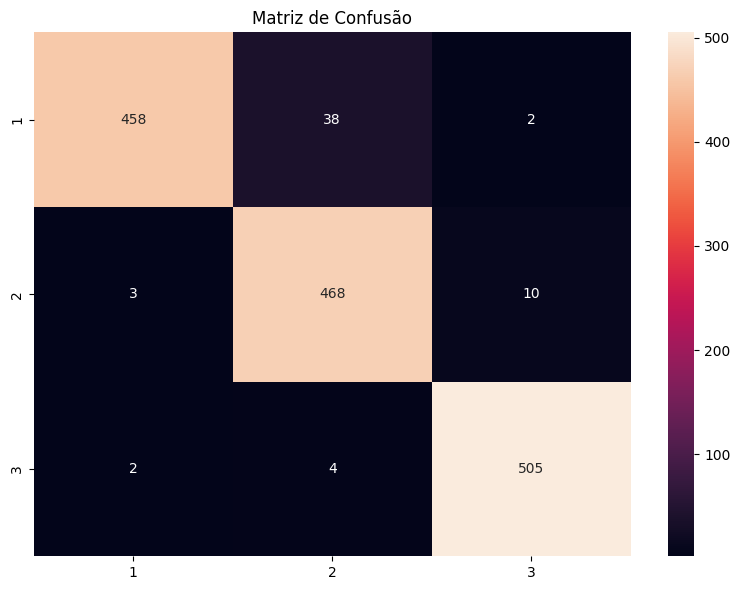

Area sob a curva ROC por classe:


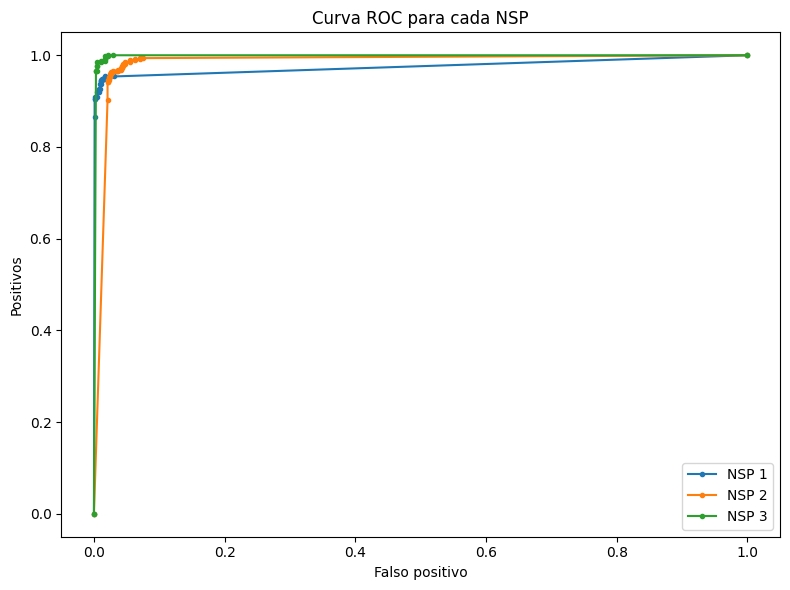

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor PRECISAO no conjunto de treinamento: 0.9612828110357243
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9618453224980051
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9604280623960098
Fbeta no conjunto de teste (com beta = 2): 0.9602485861781636
Área sob a curva ROC no conjunto de teste: 0.9861119411956043
Matriz de confusão:


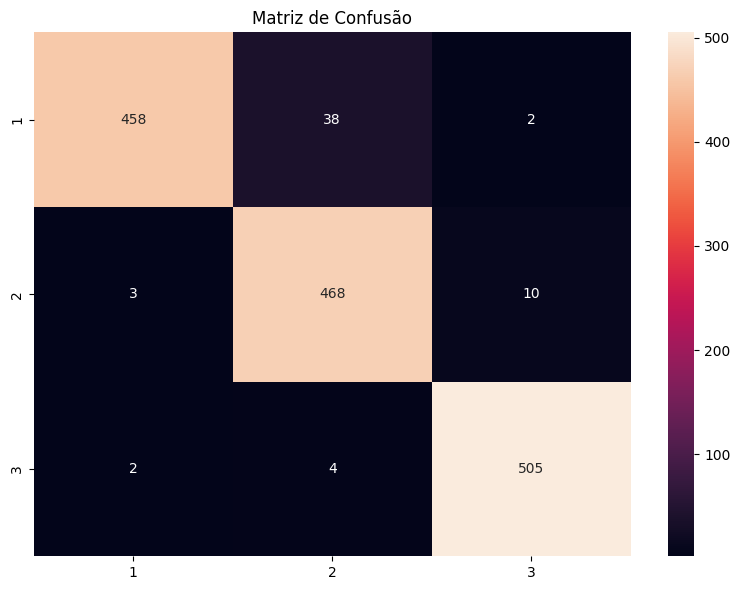

Area sob a curva ROC por classe:


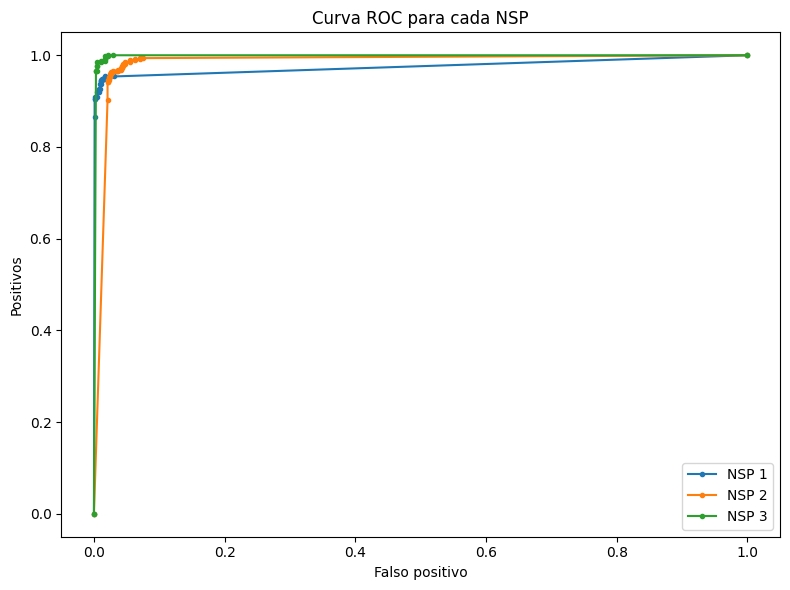

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor REVOCACAO no conjunto de treinamento: 0.9597113186922389
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9618453224980051
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9604280623960098
Fbeta no conjunto de teste (com beta = 2): 0.9602485861781636
Área sob a curva ROC no conjunto de teste: 0.9861119411956043
Matriz de confusão:


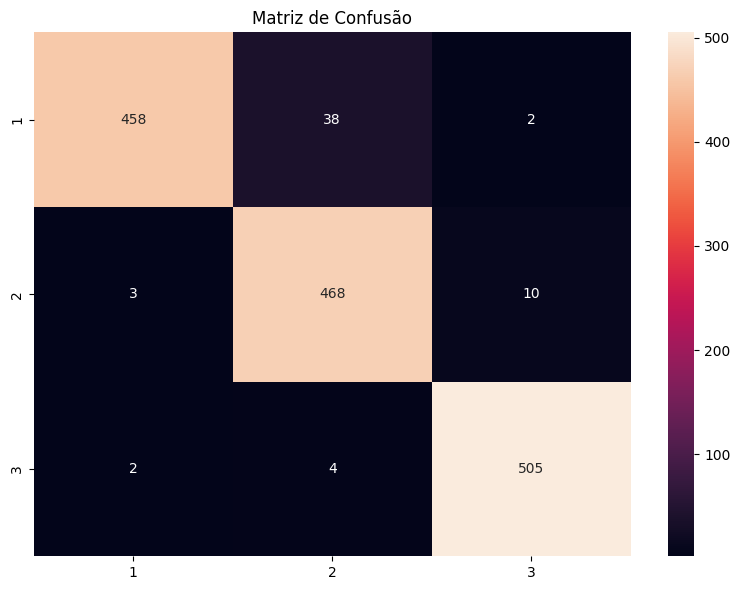

Area sob a curva ROC por classe:


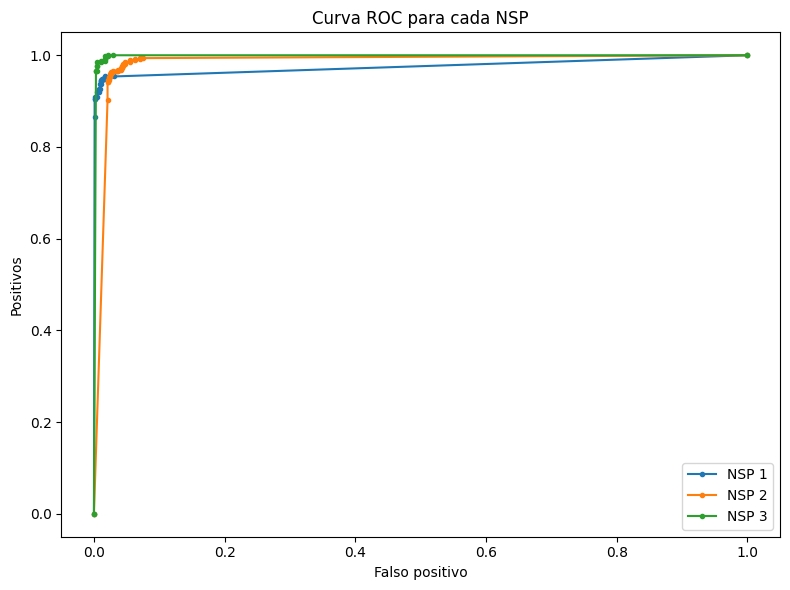

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor F1 no conjunto de treinamento: 0.9596677811386634
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9618453224980051
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9604280623960098
Fbeta no conjunto de teste (com beta = 2): 0.9602485861781636
Área sob a curva ROC no conjunto de teste: 0.9861119411956043
Matriz de confusão:


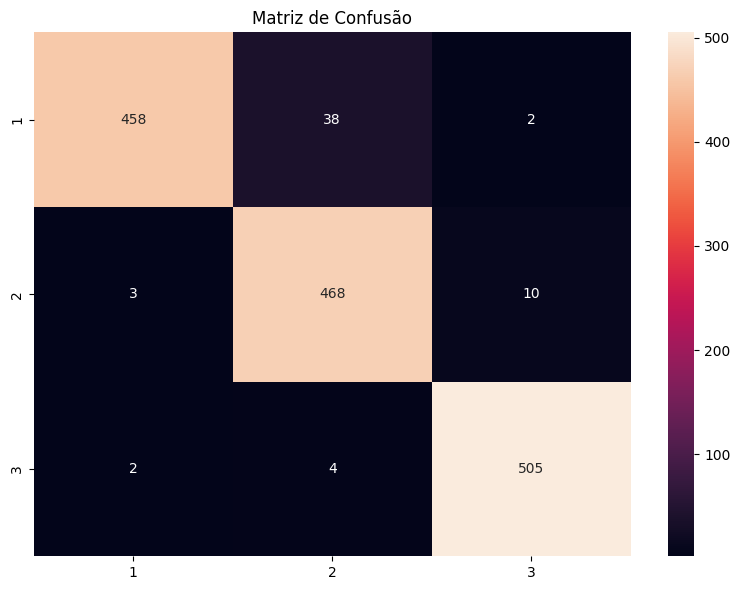

Area sob a curva ROC por classe:


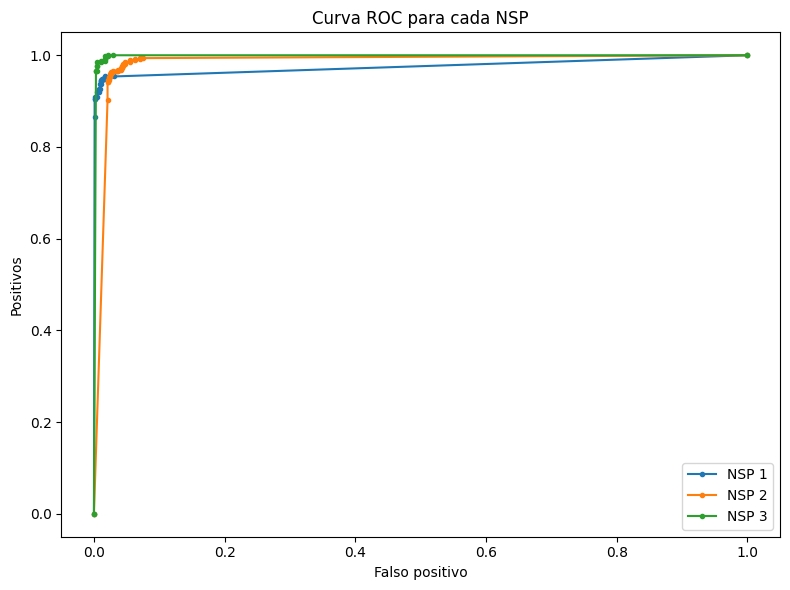

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor Fbeta_2 no conjunto de treinamento: 0.9594982322477751
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9618453224980051
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9604280623960098
Fbeta no conjunto de teste (com beta = 2): 0.9602485861781636
Área sob a curva ROC no conjunto de teste: 0.9861119411956043
Matriz de confusão:


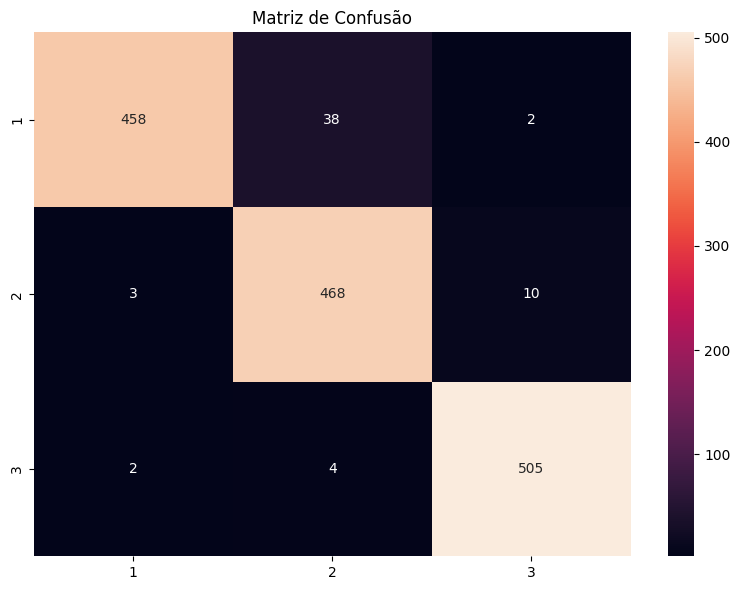

Area sob a curva ROC por classe:


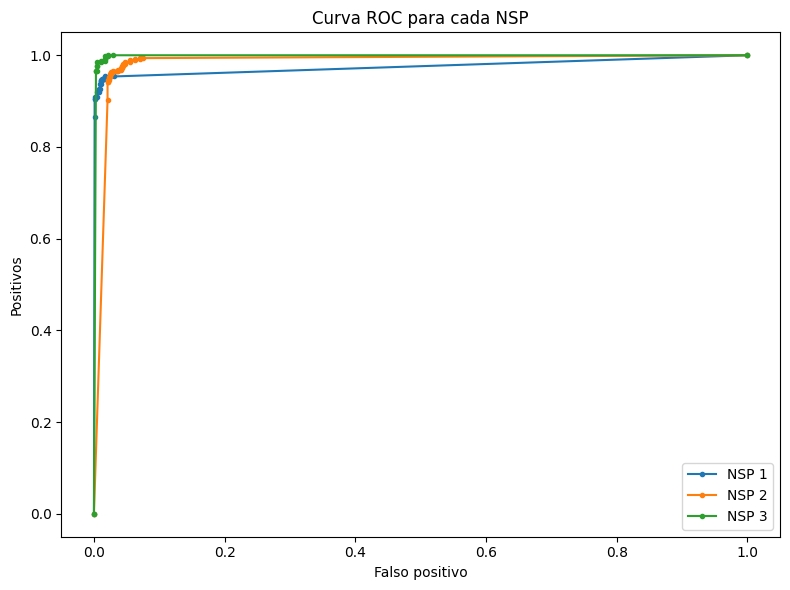

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9921738783077048
ACURÁCIA no conjunto de teste: 0.9483221476510068
PRECISÃO no conjunto de teste: 0.9515802502722607
REVOCAÇÃO no conjunto de teste: 0.9483221476510068
F1 no conjunto de teste: 0.9481995693897664
Fbeta no conjunto de teste (com beta = 2): 0.9478665186449997
Área sob a curva ROC no conjunto de teste: 0.9924550767886572
Matriz de confusão:


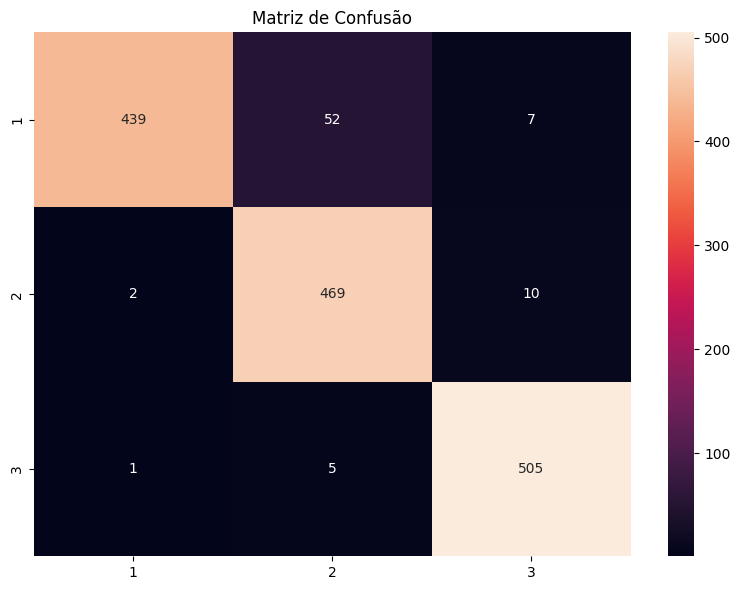

Area sob a curva ROC por classe:


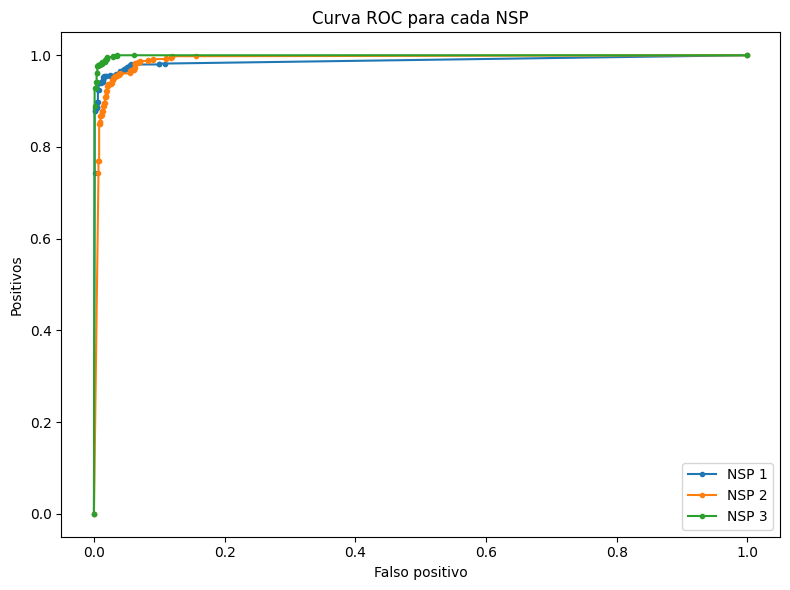

2024/08/11 22:14:11 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree' does not exist. Creating a new experiment.


=== Treinando DecisionTree ===
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ACURACIA no conjunto de treinamento: 0.9548229487561694
ACURÁCIA no conjunto de teste: 0.9570469798657718
PRECISÃO no conjunto de teste: 0.9574558539376222
REVOCAÇÃO no conjunto de teste: 0.9570469798657718
F1 no conjunto de teste: 0.9569610027683197
Fbeta no conjunto de teste (com beta = 2): 0.9569441790089958
Área sob a curva ROC no conjunto de teste: 0.9679387650834081
Matriz de confusão:


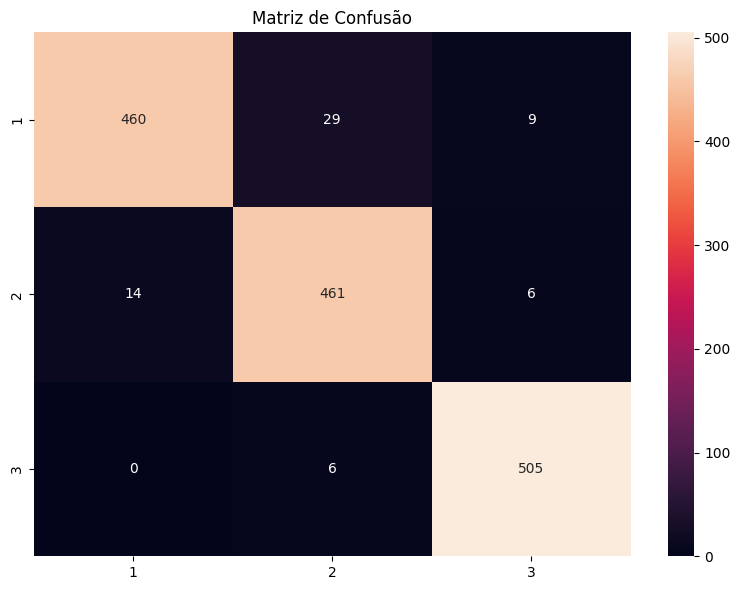

Area sob a curva ROC por classe:


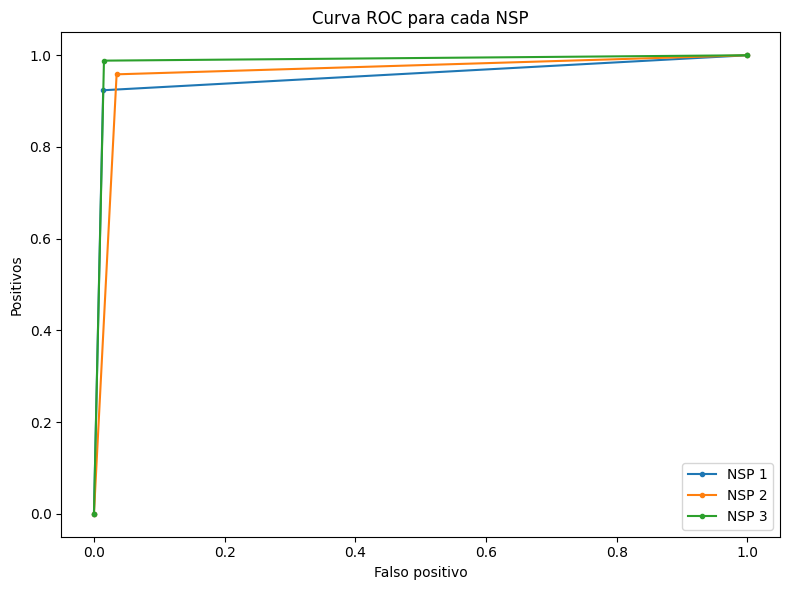

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor PRECISAO no conjunto de treinamento: 0.9550981877230997
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9607344220216689
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9603773092468816
Fbeta no conjunto de teste (com beta = 2): 0.9603471599690839
Área sob a curva ROC no conjunto de teste: 0.9704620210503896
Matriz de confusão:


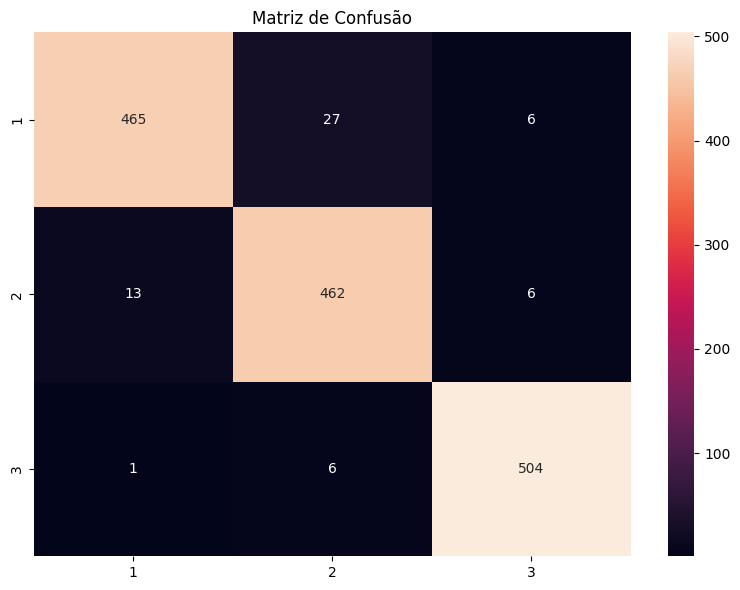

Area sob a curva ROC por classe:


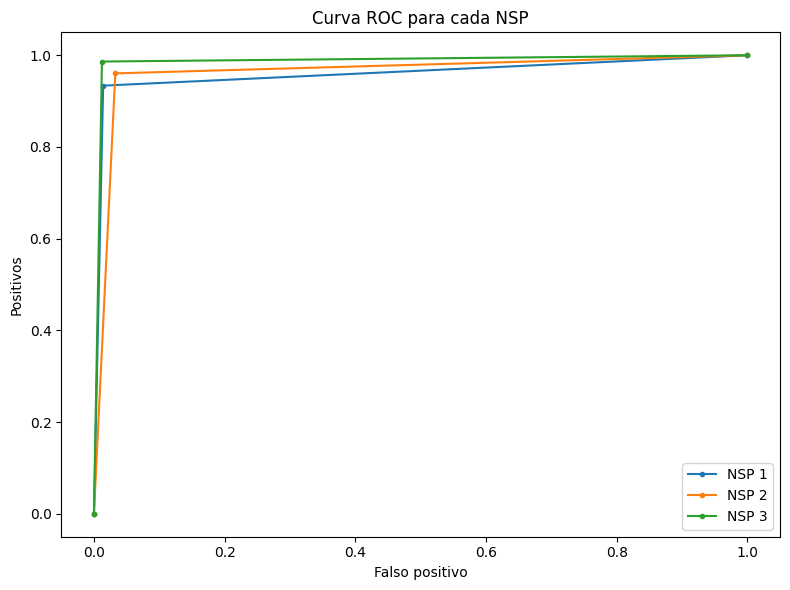

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor REVOCACAO no conjunto de treinamento: 0.9545389048991355
ACURÁCIA no conjunto de teste: 0.9570469798657718
PRECISÃO no conjunto de teste: 0.9572758098074403
REVOCAÇÃO no conjunto de teste: 0.9570469798657718
F1 no conjunto de teste: 0.9569965150003836
Fbeta no conjunto de teste (com beta = 2): 0.9569877264297777
Área sob a curva ROC no conjunto de teste: 0.9679436589076186
Matriz de confusão:


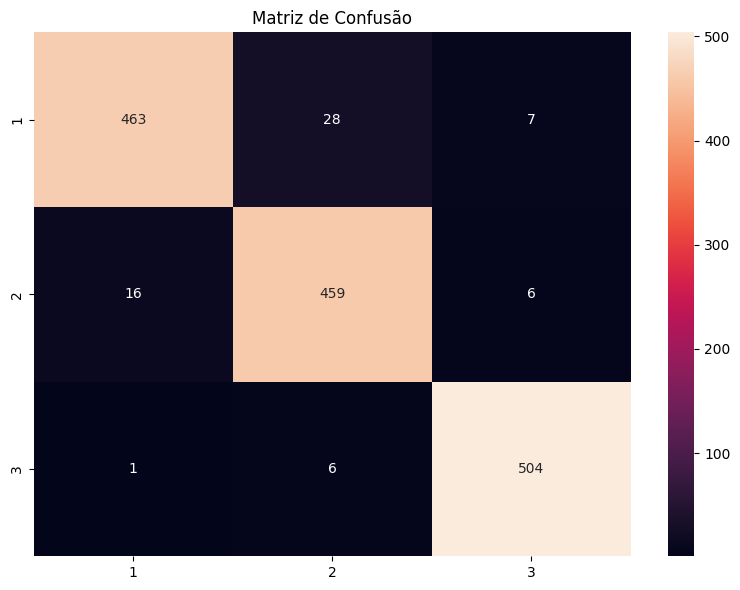

Area sob a curva ROC por classe:


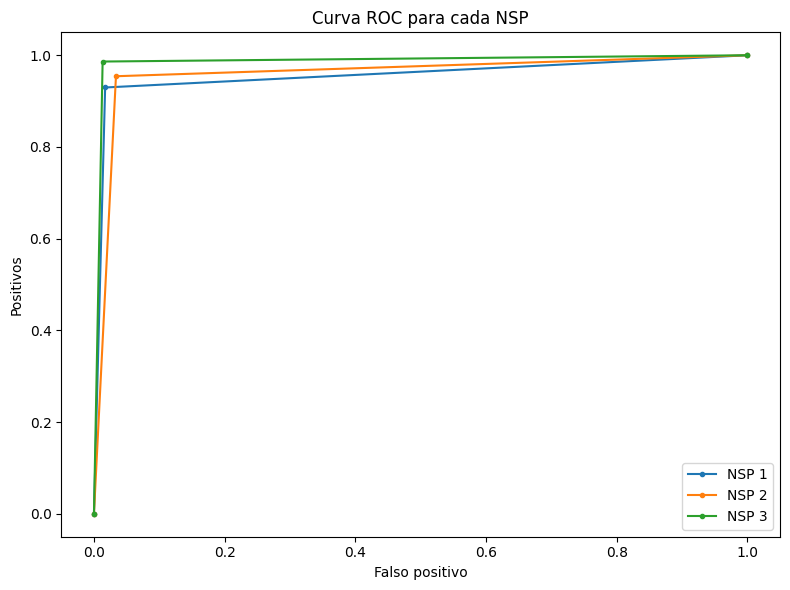

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor F1 no conjunto de treinamento: 0.9553903265693927
ACURÁCIA no conjunto de teste: 0.9583892617449664
PRECISÃO no conjunto de teste: 0.9587093385763767
REVOCAÇÃO no conjunto de teste: 0.9583892617449664
F1 no conjunto de teste: 0.9583239531295816
Fbeta no conjunto de teste (com beta = 2): 0.9583098658098146
Área sob a curva ROC no conjunto de teste: 0.9689517234237474
Matriz de confusão:


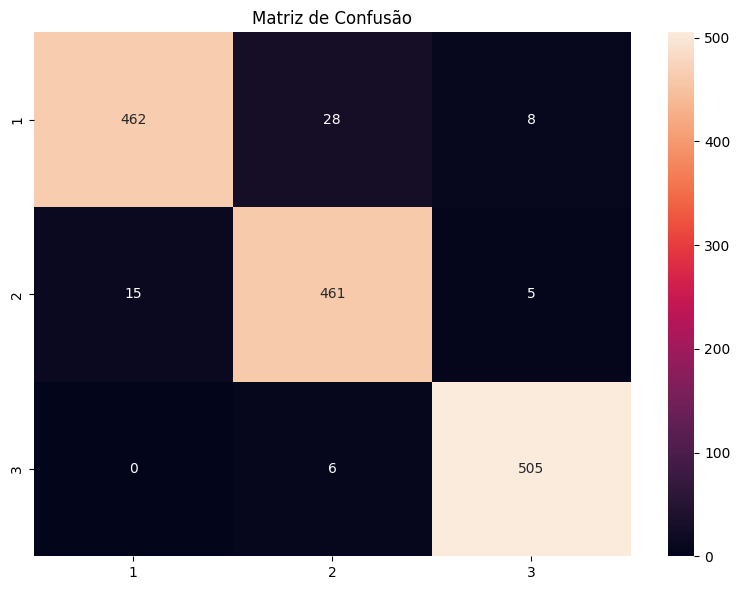

Area sob a curva ROC por classe:


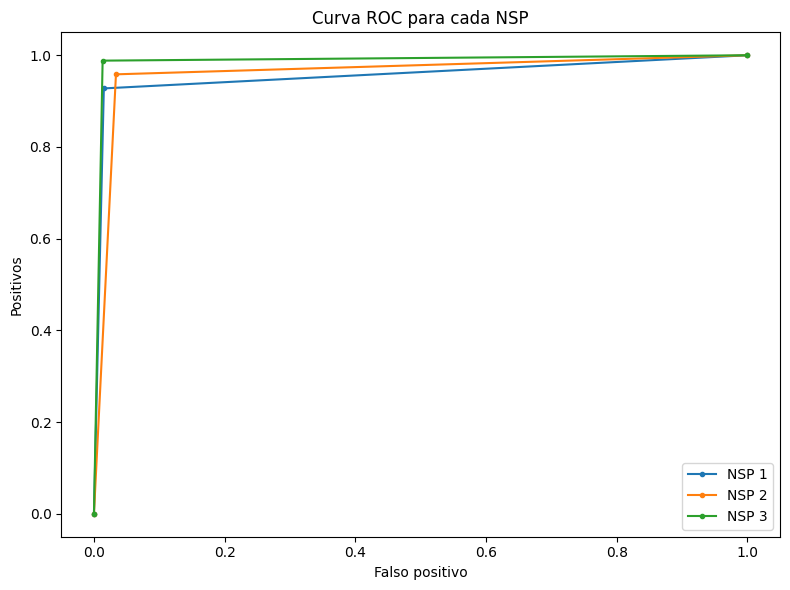

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor Fbeta_2 no conjunto de treinamento: 0.9556197211541934
ACURÁCIA no conjunto de teste: 0.9604026845637584
PRECISÃO no conjunto de teste: 0.9607529615102111
REVOCAÇÃO no conjunto de teste: 0.9604026845637584
F1 no conjunto de teste: 0.9603515981762762
Fbeta no conjunto de teste (com beta = 2): 0.9603287706051394
Área sob a curva ROC no conjunto de teste: 0.9704401429875528
Matriz de confusão:


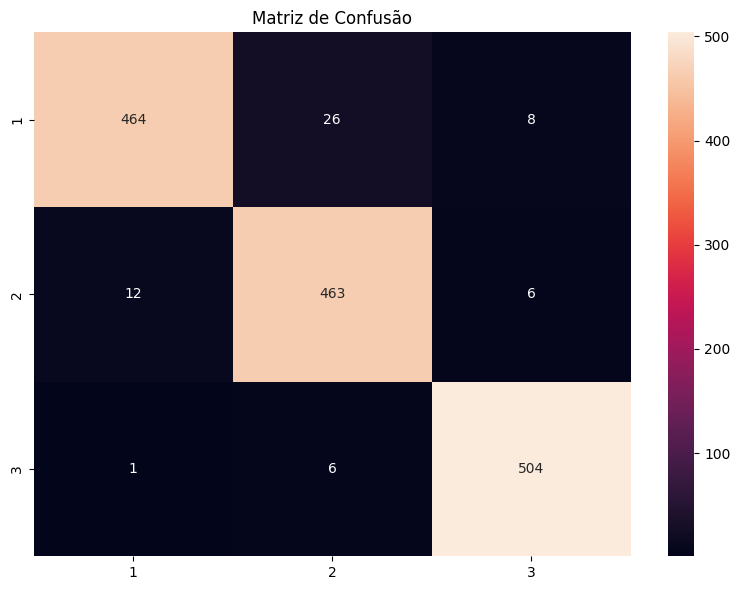

Area sob a curva ROC por classe:


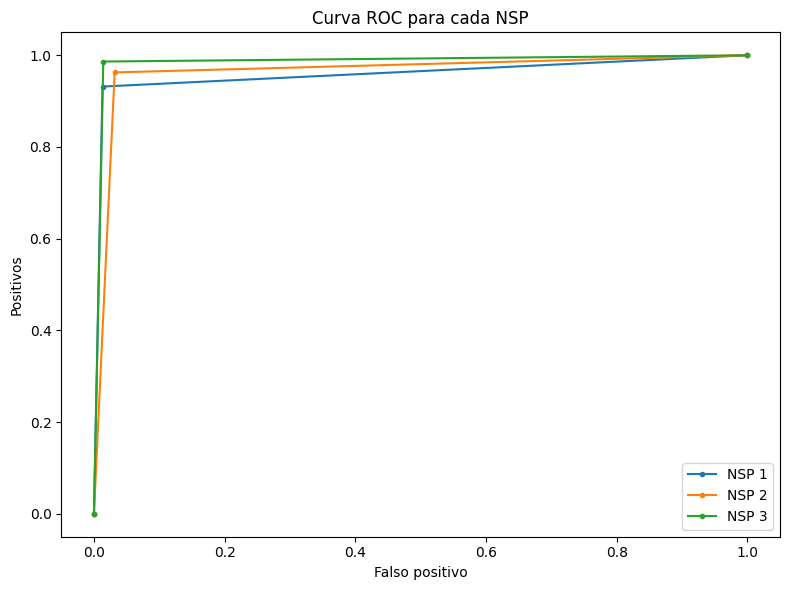

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9721428043372041
ACURÁCIA no conjunto de teste: 0.959731543624161
PRECISÃO no conjunto de teste: 0.9599470611608939
REVOCAÇÃO no conjunto de teste: 0.959731543624161
F1 no conjunto de teste: 0.9597434154029872
Fbeta no conjunto de teste (com beta = 2): 0.9597133888128677
Área sob a curva ROC no conjunto de teste: 0.9813551584867841
Matriz de confusão:


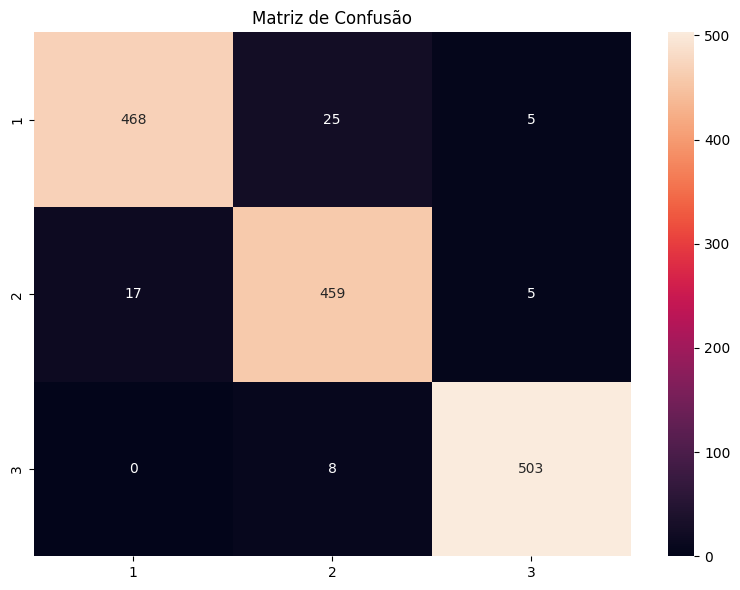

Area sob a curva ROC por classe:


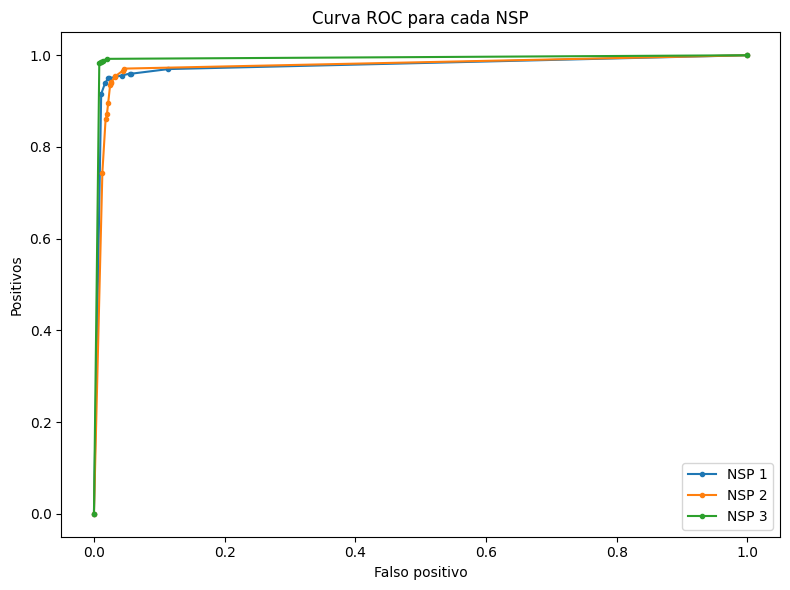

2024/08/11 22:14:27 INFO mlflow.tracking.fluent: Experiment with name 'MLP' does not exist. Creating a new experiment.


=== Treinando MLP ===
Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ACURACIA no conjunto de treinamento: 0.962015137964159
ACURÁCIA no conjunto de teste: 0.9610738255033557
PRECISÃO no conjunto de teste: 0.9628942463759578
REVOCAÇÃO no conjunto de teste: 0.9610738255033557
F1 no conjunto de teste: 0.9611025849621692
Fbeta no conjunto de teste (com beta = 2): 0.960876044017686
Área sob a curva ROC no conjunto de teste: 0.9964078502290704
Matriz de confusão:


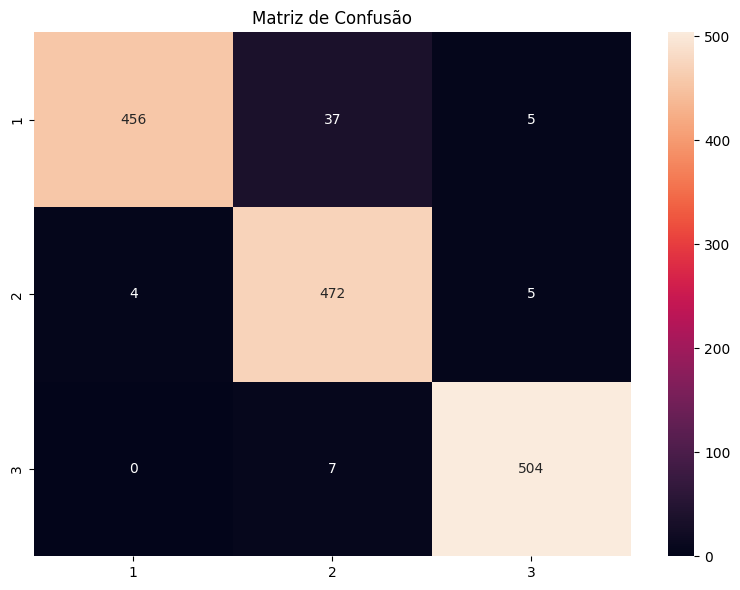

Area sob a curva ROC por classe:


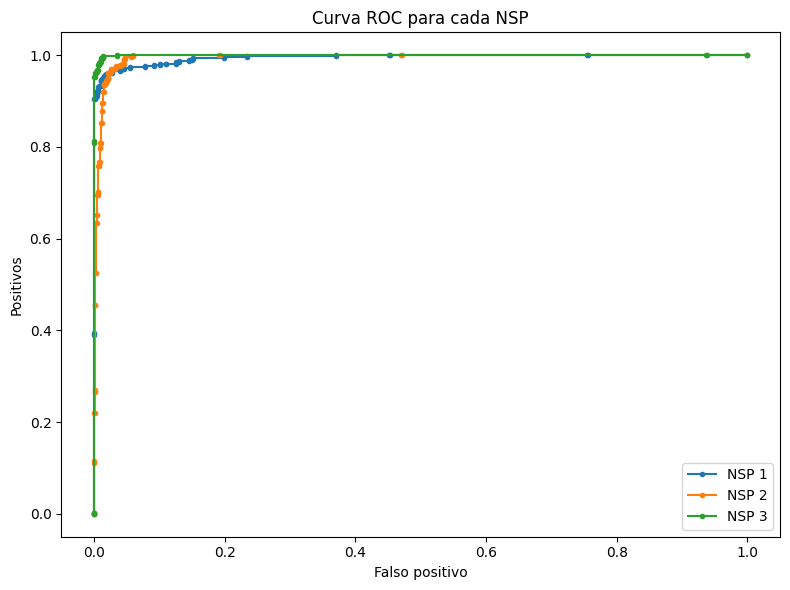

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor PRECISAO no conjunto de treinamento: 0.9659122450467678
ACURÁCIA no conjunto de teste: 0.9563758389261745
PRECISÃO no conjunto de teste: 0.9577847485033706
REVOCAÇÃO no conjunto de teste: 0.9563758389261745
F1 no conjunto de teste: 0.9564955471108382
Fbeta no conjunto de teste (com beta = 2): 0.9562823154090081
Área sob a curva ROC no conjunto de teste: 0.9951677920766557
Matriz de confusão:


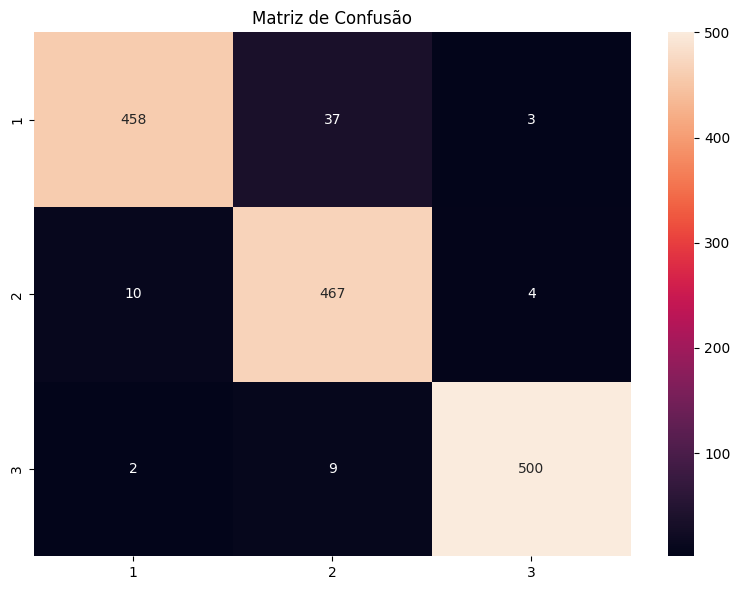

Area sob a curva ROC por classe:


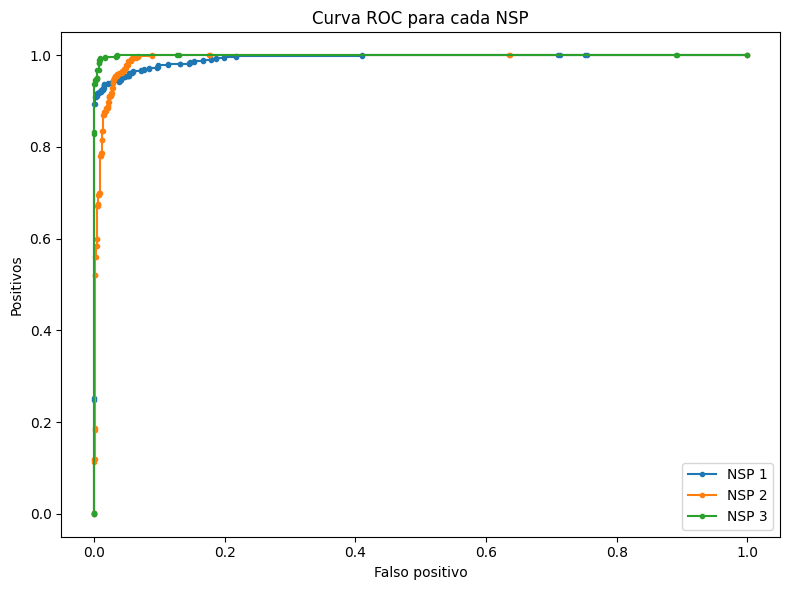

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor REVOCACAO no conjunto de treinamento: 0.9654733512206433
ACURÁCIA no conjunto de teste: 0.9751677852348993
PRECISÃO no conjunto de teste: 0.9760681533258038
REVOCAÇÃO no conjunto de teste: 0.9751677852348993
F1 no conjunto de teste: 0.9751649732958438
Fbeta no conjunto de teste (com beta = 2): 0.9750586075396266
Área sob a curva ROC no conjunto de teste: 0.9964854720467547
Matriz de confusão:


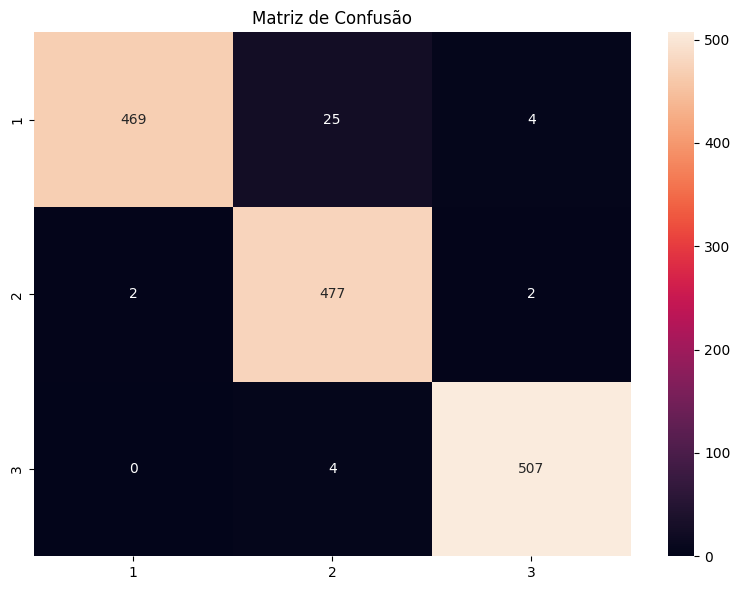

Area sob a curva ROC por classe:


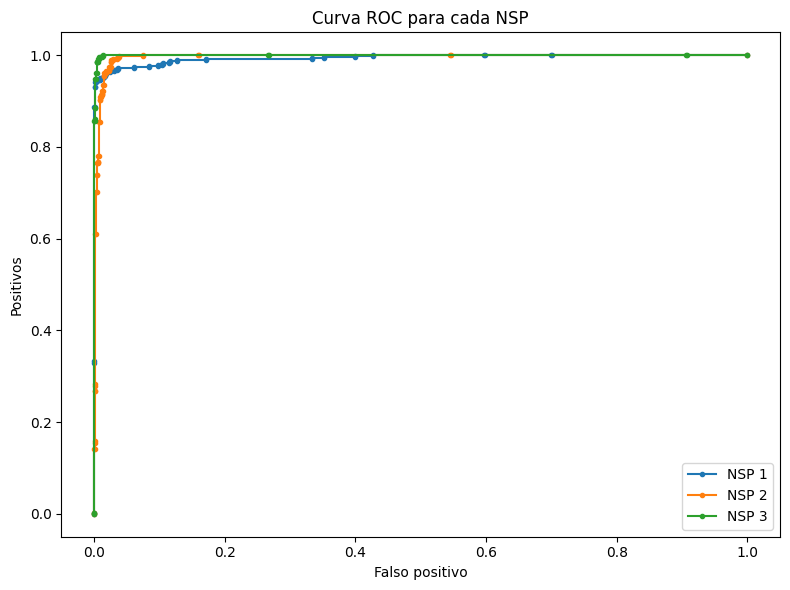

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor F1 no conjunto de treinamento: 0.9634274877244489
ACURÁCIA no conjunto de teste: 0.9677852348993289
PRECISÃO no conjunto de teste: 0.9683949467587941
REVOCAÇÃO no conjunto de teste: 0.9677852348993289
F1 no conjunto de teste: 0.9678141650113866
Fbeta no conjunto de teste (com beta = 2): 0.9677304602700725
Área sob a curva ROC no conjunto de teste: 0.9956667686840067
Matriz de confusão:


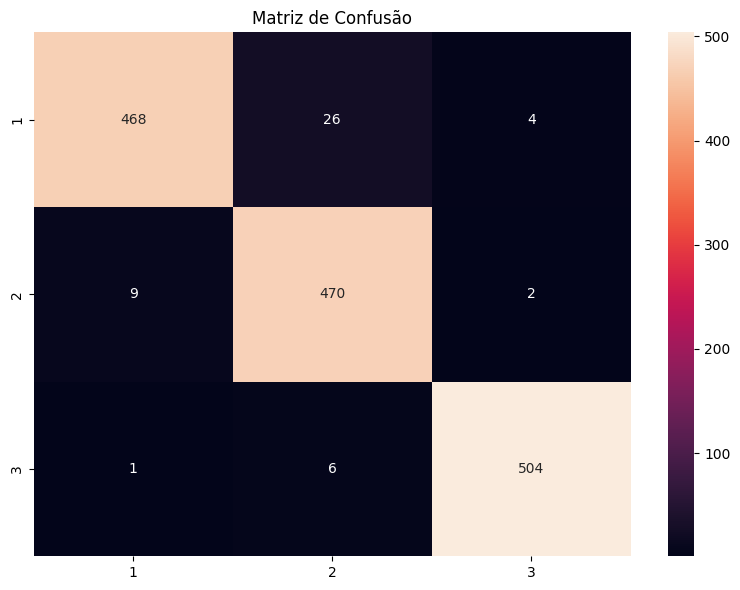

Area sob a curva ROC por classe:


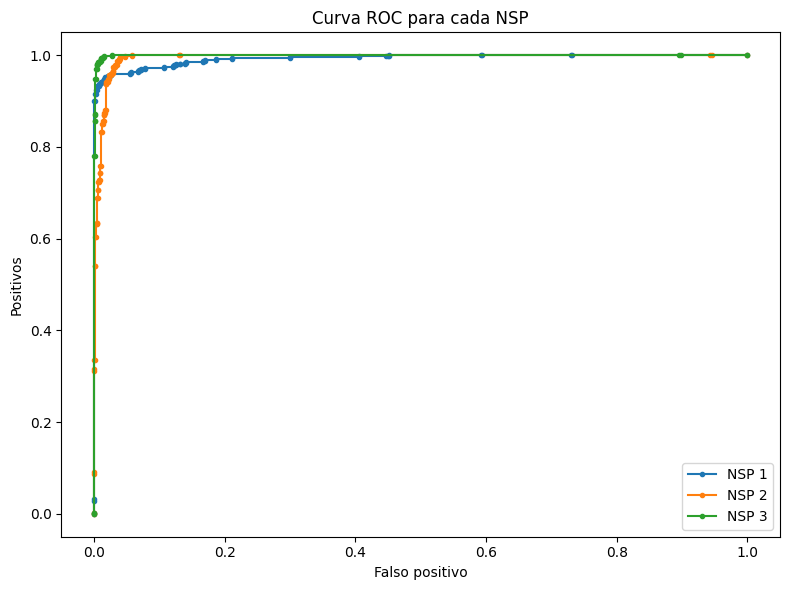

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor Fbeta_2 no conjunto de treinamento: 0.9633742748007311
ACURÁCIA no conjunto de teste: 0.9711409395973154
PRECISÃO no conjunto de teste: 0.9713080265218005
REVOCAÇÃO no conjunto de teste: 0.9711409395973154
F1 no conjunto de teste: 0.9710910871858759
Fbeta no conjunto de teste (com beta = 2): 0.9710893268603639
Área sob a curva ROC no conjunto de teste: 0.9961315671157173
Matriz de confusão:


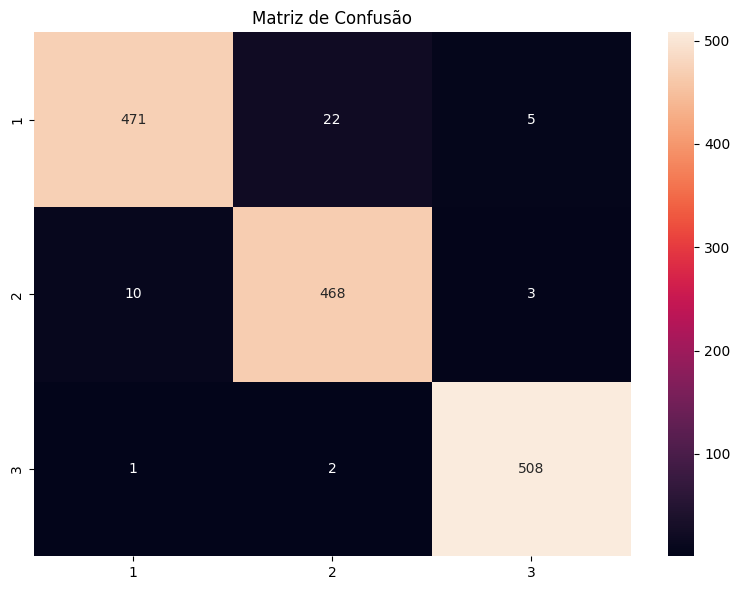

Area sob a curva ROC por classe:


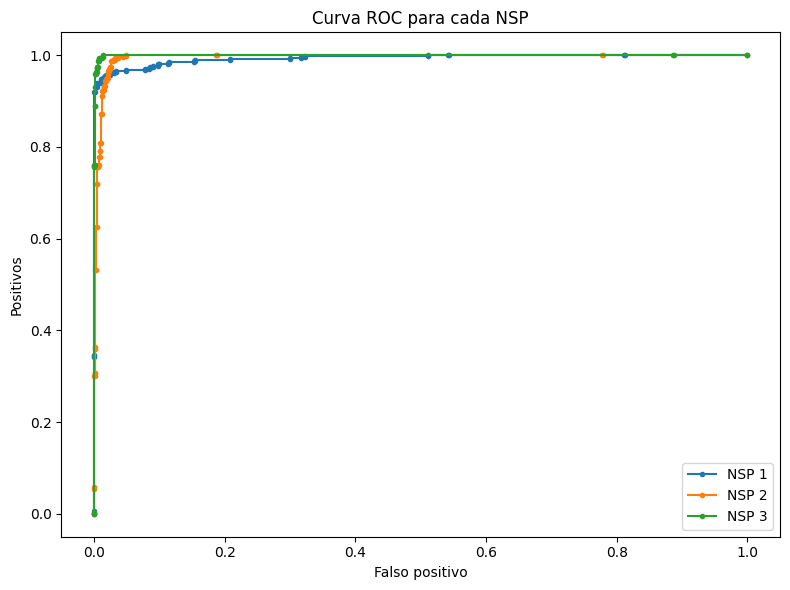

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Melhor ROC_AUC no conjunto de treinamento: 0.9939225494593646
ACURÁCIA no conjunto de teste: 0.951006711409396
PRECISÃO no conjunto de teste: 0.9519671663926074
REVOCAÇÃO no conjunto de teste: 0.951006711409396
F1 no conjunto de teste: 0.9509286095447826
Fbeta no conjunto de teste (com beta = 2): 0.9508447710464227
Área sob a curva ROC no conjunto de teste: 0.9927018255436768
Matriz de confusão:


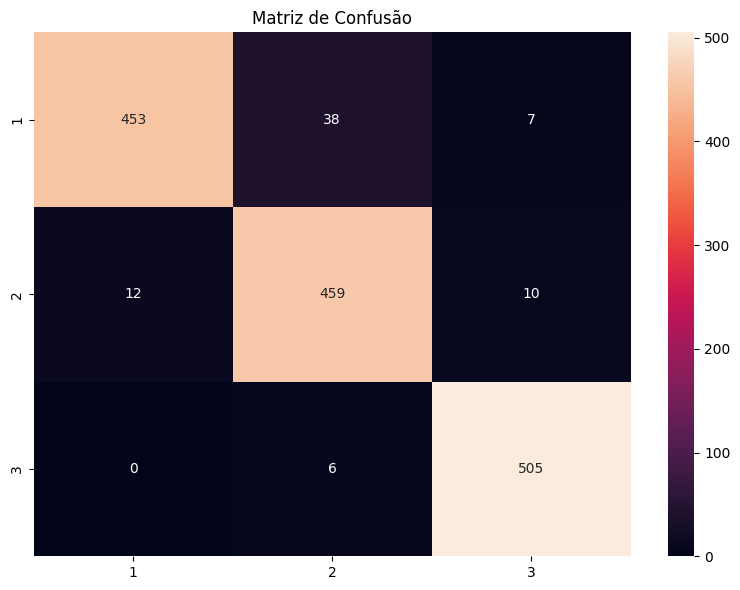

Area sob a curva ROC por classe:


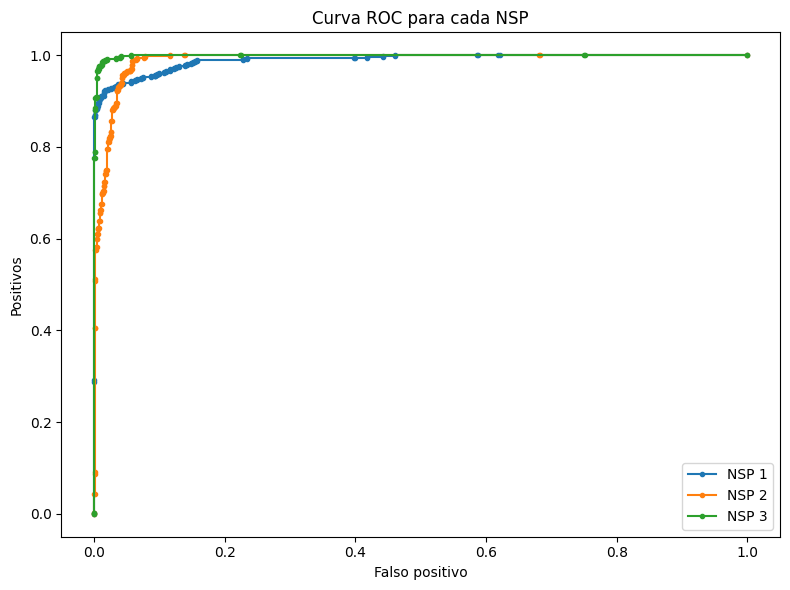

2024/08/11 22:21:42 INFO mlflow.tracking.fluent: Experiment with name 'Naive Bayes' does not exist. Creating a new experiment.


=== Treinando NaiveBayes ===
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ACURACIA no conjunto de treinamento: 0.7599986750140779
ACURÁCIA no conjunto de teste: 0.7657718120805369
PRECISÃO no conjunto de teste: 0.8218010221753687
REVOCAÇÃO no conjunto de teste: 0.7657718120805369
F1 no conjunto de teste: 0.7704346306122019
Fbeta no conjunto de teste (com beta = 2): 0.7616187261112144
Área sob a curva ROC no conjunto de teste: 0.9056595715802619
Matriz de confusão:


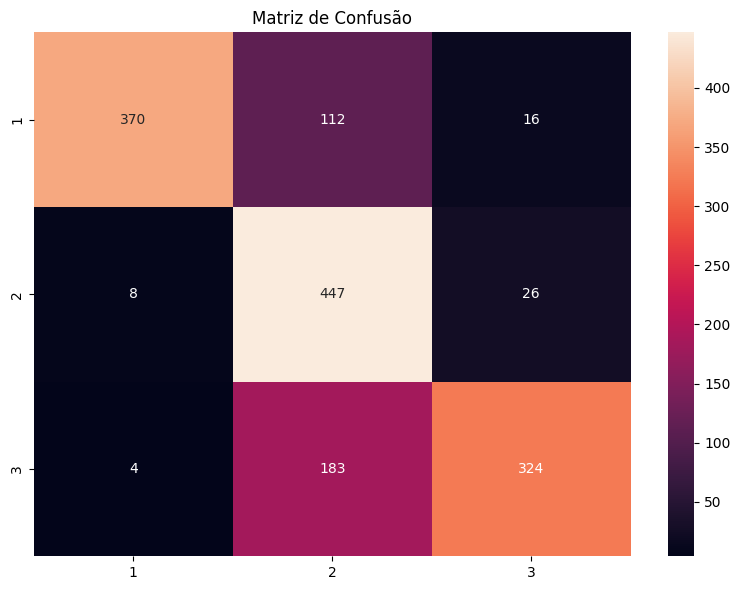

Area sob a curva ROC por classe:


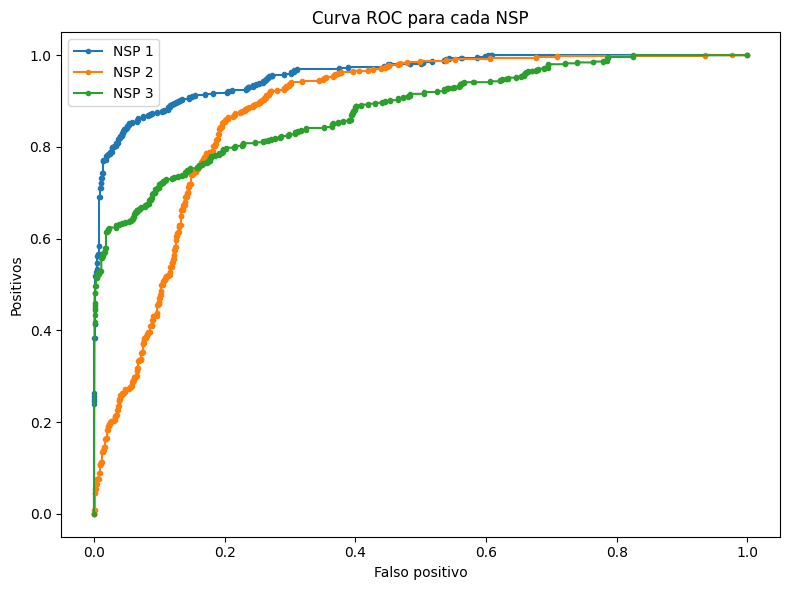

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor PRECISAO no conjunto de treinamento: 0.8145456551319576
ACURÁCIA no conjunto de teste: 0.7630872483221477
PRECISÃO no conjunto de teste: 0.8242323555839276
REVOCAÇÃO no conjunto de teste: 0.7630872483221477
F1 no conjunto de teste: 0.7678044709441715
Fbeta no conjunto de teste (com beta = 2): 0.7583208896104773
Área sob a curva ROC no conjunto de teste: 0.9030998828859798
Matriz de confusão:


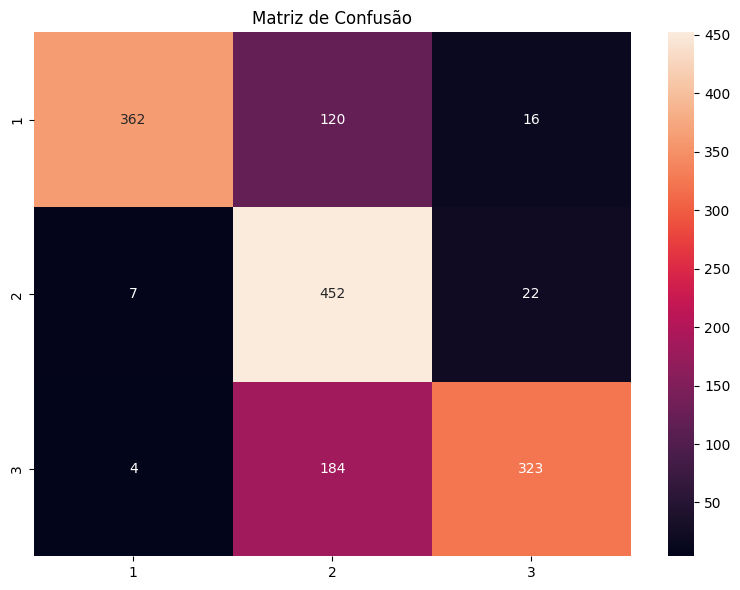

Area sob a curva ROC por classe:


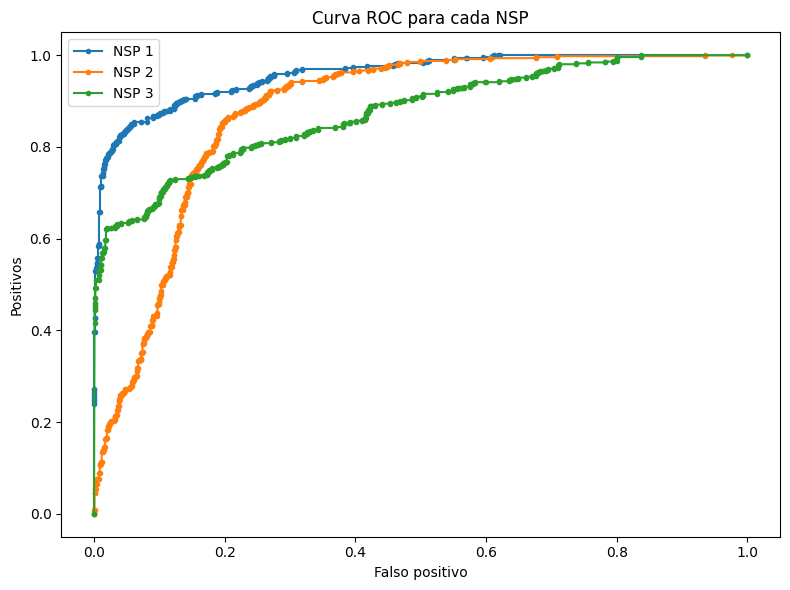

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor REVOCACAO no conjunto de treinamento: 0.7599986750140779
ACURÁCIA no conjunto de teste: 0.7657718120805369
PRECISÃO no conjunto de teste: 0.8218010221753687
REVOCAÇÃO no conjunto de teste: 0.7657718120805369
F1 no conjunto de teste: 0.7704346306122019
Fbeta no conjunto de teste (com beta = 2): 0.7616187261112144
Área sob a curva ROC no conjunto de teste: 0.9056595715802619
Matriz de confusão:


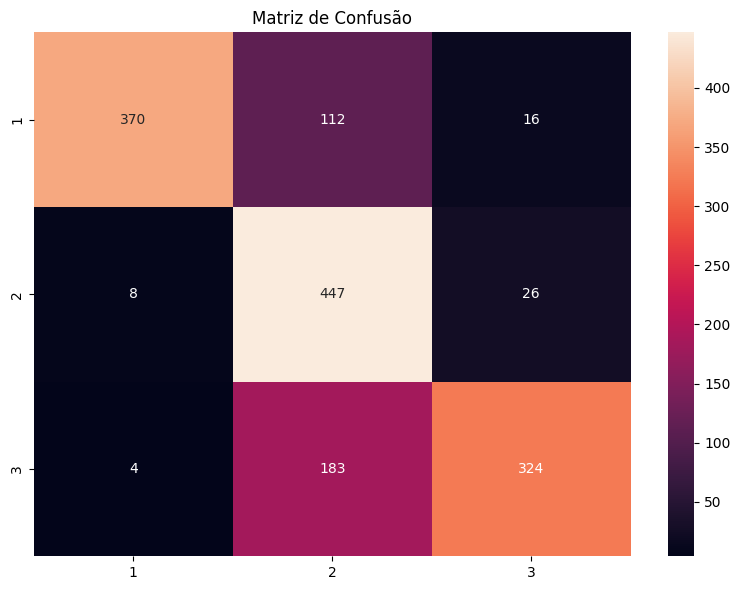

Area sob a curva ROC por classe:


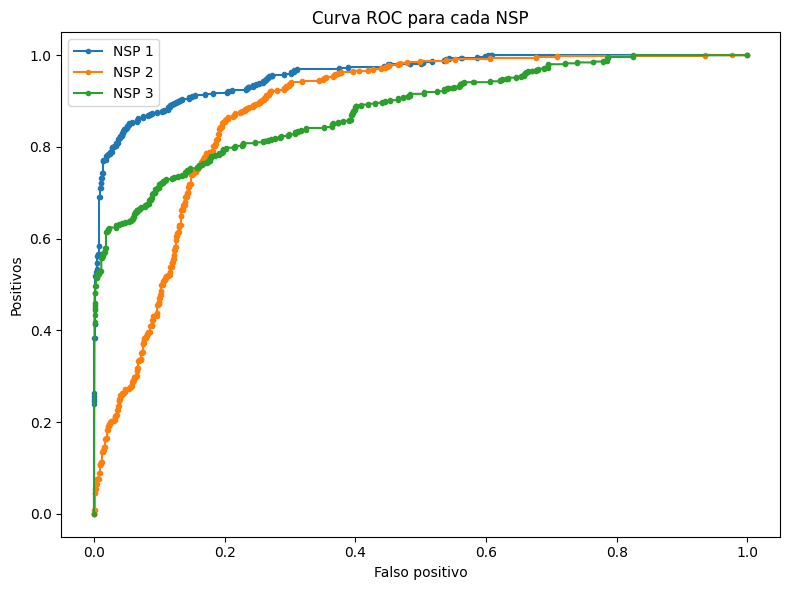

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor F1 no conjunto de treinamento: 0.7624293880073786
ACURÁCIA no conjunto de teste: 0.7657718120805369
PRECISÃO no conjunto de teste: 0.8218010221753687
REVOCAÇÃO no conjunto de teste: 0.7657718120805369
F1 no conjunto de teste: 0.7704346306122019
Fbeta no conjunto de teste (com beta = 2): 0.7616187261112144
Área sob a curva ROC no conjunto de teste: 0.9056595715802619
Matriz de confusão:


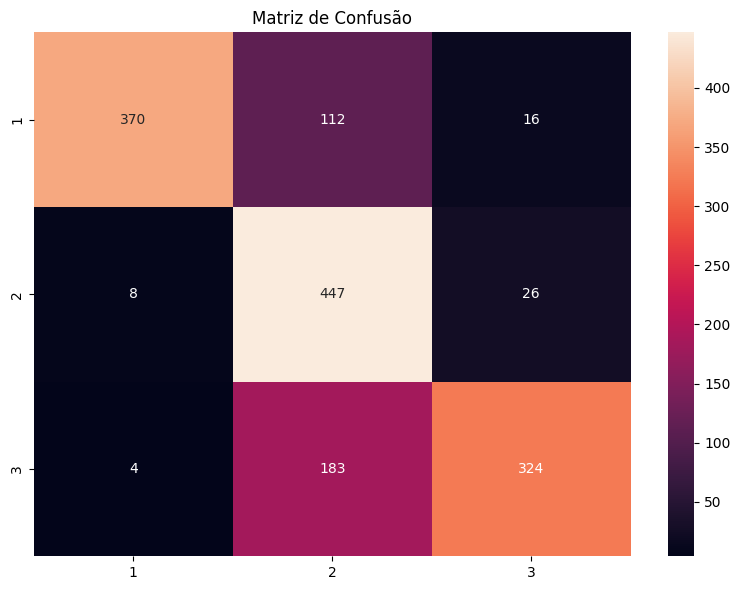

Area sob a curva ROC por classe:


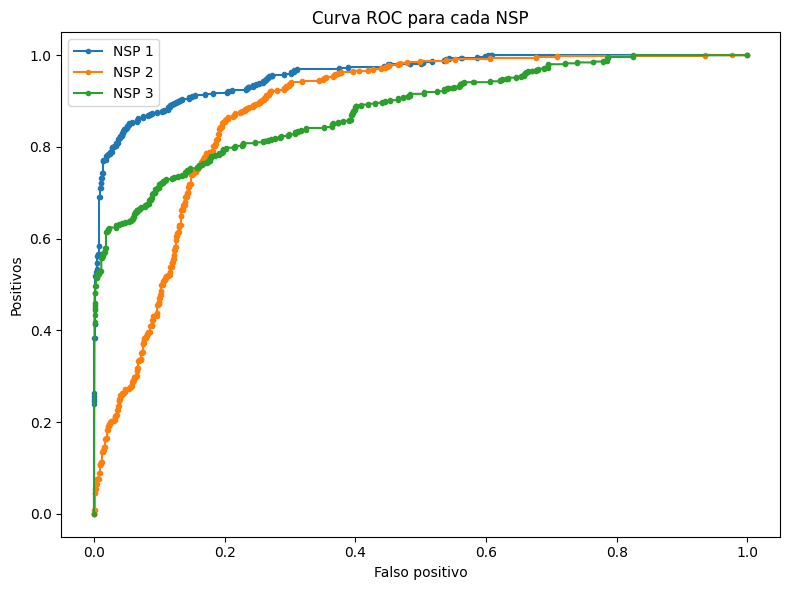

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor Fbeta_2 no conjunto de treinamento: 0.7551748311947872
ACURÁCIA no conjunto de teste: 0.7657718120805369
PRECISÃO no conjunto de teste: 0.8218010221753687
REVOCAÇÃO no conjunto de teste: 0.7657718120805369
F1 no conjunto de teste: 0.7704346306122019
Fbeta no conjunto de teste (com beta = 2): 0.7616187261112144
Área sob a curva ROC no conjunto de teste: 0.9056595715802619
Matriz de confusão:


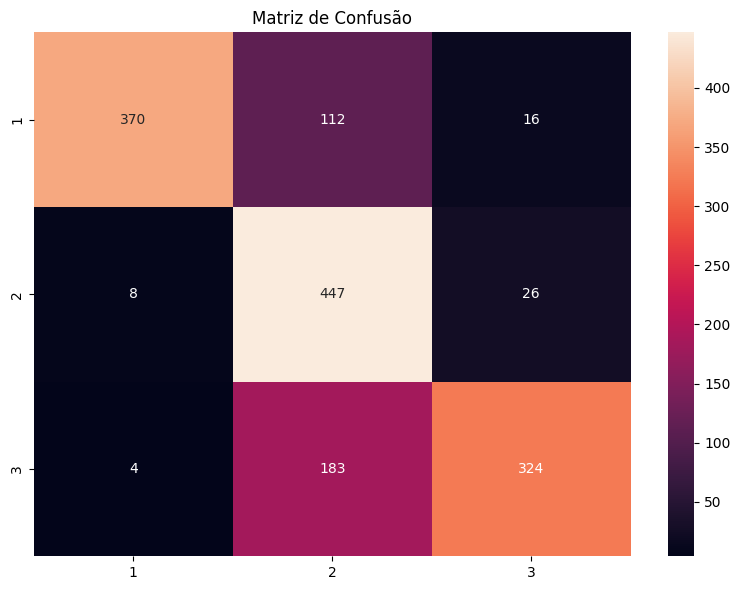

Area sob a curva ROC por classe:


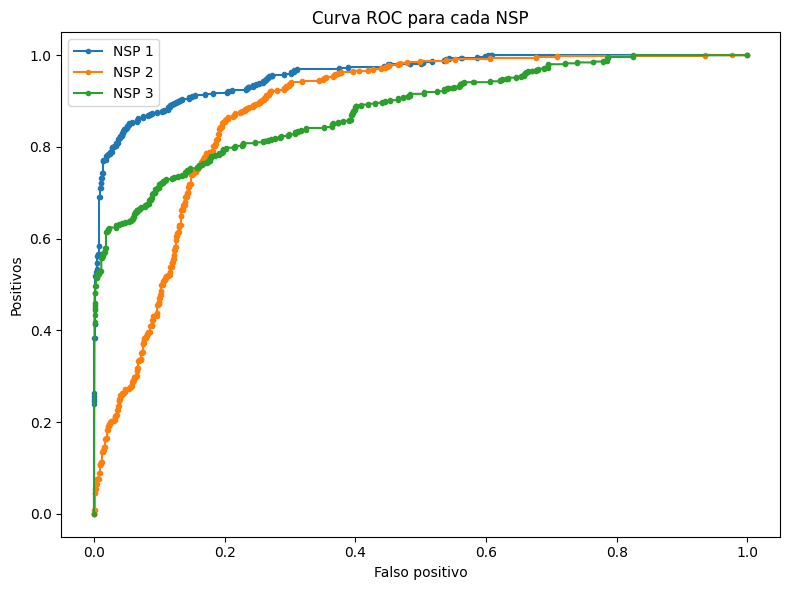

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Melhor ROC_AUC no conjunto de treinamento: 0.8904689471695748
ACURÁCIA no conjunto de teste: 0.7657718120805369
PRECISÃO no conjunto de teste: 0.8218010221753687
REVOCAÇÃO no conjunto de teste: 0.7657718120805369
F1 no conjunto de teste: 0.7704346306122019
Fbeta no conjunto de teste (com beta = 2): 0.7616187261112144
Área sob a curva ROC no conjunto de teste: 0.9056595715802619
Matriz de confusão:


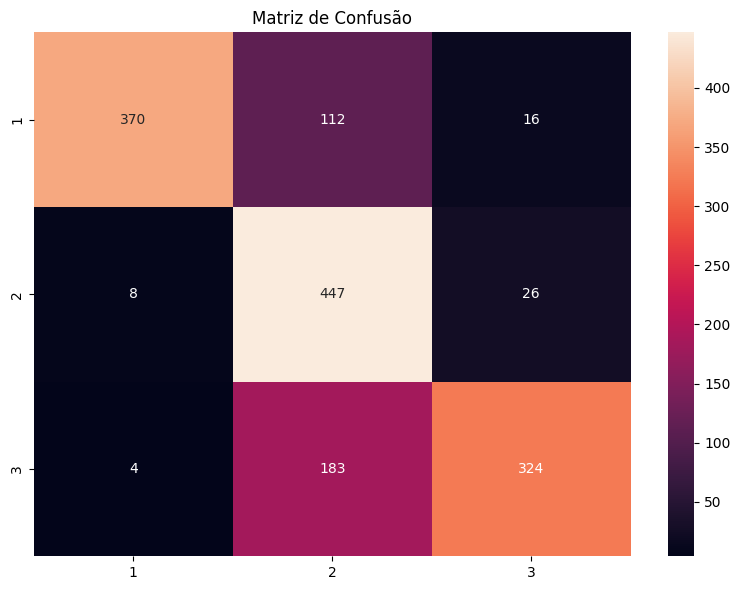

Area sob a curva ROC por classe:


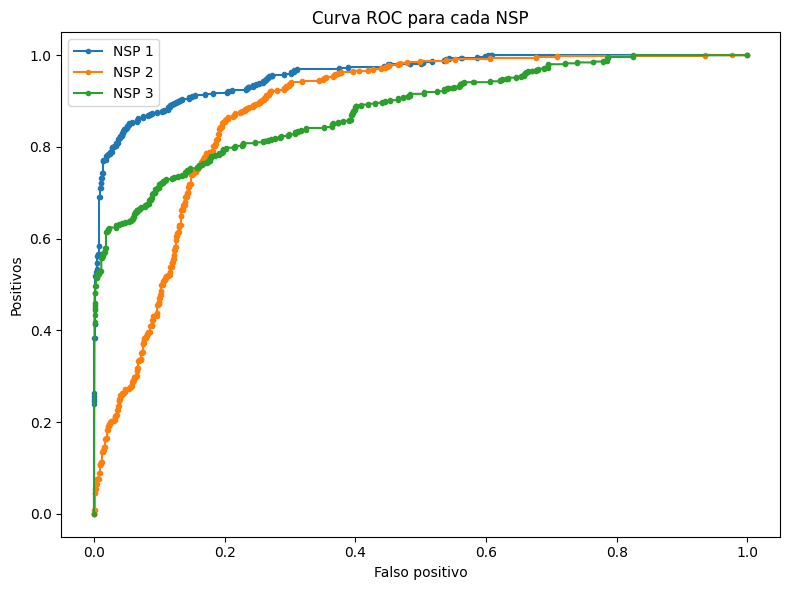

In [ ]:
get_ipython().system_raw("mlflow ui --port 5000 &")
for clf_name, clf_info in classifiers.items():
    # experimento MLflow
    mlflow.set_experiment(experiment_mapping[clf_name])

    print(f"=== Treinando {clf_name} ===")

    for score_name, score_metric in scores.items():
        with mlflow.start_run(run_name=f"{clf_name}_{score_name}"):
            grid_search = GridSearchCV(
                estimator=clf_info['model'],
                param_grid=clf_info['param_grid'],
                cv=10,
                n_jobs=-1,
                verbose=1,
                scoring=score_metric
            )

            grid_search.fit(X_train, y_train)

            # registra parametros
            mlflow.log_params(grid_search.best_params_)

            # registra métricas do treinamento
            mlflow.log_metric(f"best_train_{score_name}", grid_search.best_score_)
            print(f"Melhor {score_name} no conjunto de treinamento: {grid_search.best_score_}")

            # avaliação no conjunto de testes
            test_metrics = evaluate_best_model(grid_search, X_test, y_test)
            for metric_name, metric_value in test_metrics.items():
                mlflow.log_metric(f"test_{metric_name}", metric_value)

            signature = infer_signature(X_train, grid_search.predict(X_train))
            mlflow.sklearn.log_model(grid_search.best_estimator_, f"{clf_name}_model", signature=signature)

            # Optional: Log artifacts, e.g., plots, if any
            # mlflow.log_artifact("path_to_artifact")

            mlflow.end_run()


### Recuperando dados para análise

In [ ]:
ngrok.kill()
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://ce9e-35-194-31-197.ngrok-free.app
